# Logistic regression

Beyond regression, another important data analysis task is _classification_, in which you are given a set of labeled data points and you wish to learn a model of the labels. The canonical example of a classification algorithm is _logistic regression_, the topic of this notebook.

> Although it's called "regression" it is really a model for classification.

Here, you'll consider _binary classification_. Each data point belongs to one of $c=2$ possible classes. By convention, we will denote these _class labels_ by "0" and "1." However, the ideas can be generalized to the multiclass case, i.e., $c > 2$, with labels $\{0, 1, \ldots, c-1\}$.

You'll also want to review from earlier notebooks the concept of gradient ascent/descent (or "steepest ascent/descent"), when optimizing a scalar function of a vector variable.

# Part 0: Introduction

This part of the notebook introduces you to the classification problem through a "geometric interpretation."

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math

%matplotlib inline

import matplotlib as mpl
mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures

**A note about slicing columns from a Numpy matrix.** If you want to extract a column `i` from a Numpy matrix `A` _and_ keep it as a column vector, you need to use the slicing notation, `A[:, i:i+1]`. Not doing so can lead to subtle bugs. To see why, compare the following slices.

In [2]:
A = np.array ([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]
              ], dtype=float)

print ("A[:, :] ==\n", A)
print ("\na0 := A[:, 0] ==\n", A[:, 0])
print ("\na1 := A[:, 2:3] == \n", A[:, 2:3])

print ("\nAdd columns 0 and 2?")
a0 = A[:, 0]
a1 = A[:, 2:3]
print (a0 + a1)

A[:, :] ==
 [[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]

a0 := A[:, 0] ==
 [1. 4. 7.]

a1 := A[:, 2:3] == 
 [[3.]
 [6.]
 [9.]]

Add columns 0 and 2?
[[ 4.  7. 10.]
 [ 7. 10. 13.]
 [10. 13. 16.]]


**Aside: Broadcasting in Numpy.** What is happening in the operation, `a0 + a1`, shown above? When the shapes of two objects do not match, Numpy tries to figure out if there is a natural way to make them compatible. Refer to the supplemental notebook included in Notebook 10 for a review of Numpy's "broadcasting rule," along with other Numpy tips.

## Example data: Rock lobsters!

As a concrete example of a classification task, consider the results of [the following experiment](http://www.stat.ufl.edu/~winner/data/lobster_survive.txt).

Some marine biologists started with a bunch of lobsters of varying sizes (size being a proxy for the stage of a lobster's development). They then tethered and exposed these lobsters to a variety of predators. Finally, the outcome that they measured is whether the lobsters survived or not.

The data is a set of points, one point per lobster, where there is a single predictor (the lobster's size) and the response is whether the lobsters survived (label "1") or died (label "0").

> For the original paper, see [this link](https://www.sciencedirect.com/science/article/pii/S0022098115000039). For what we can only guess is what marine biologists do in their labs, see [this image](http://i.imgur.com/dQDKgys.jpg) (or this [possibly not-safe-for-work alternative](http://web.archive.org/web/20120628012654/http://www.traemcneely.com/wp-content/uploads/2012/04/wpid-Lobster-Fights-e1335308484734.jpeg)).

Start by downloading this data.

In [3]:
from cse6040utils import download_all, LOCAL_BASE

datasets = {'lobster_survive.dat.txt': '12fc1c22ed9b4d7bf04bf7e0fec996b7',
            'logreg_points_train.csv': '25bbca6105bae047ac4d62ee8b76c841',
            'log_likelihood_soln.npz': '5a9e17d56937855727afa6db1cd83306',
            'grad_log_likelihood_soln.npz': 'a67c00bfa95929e12d423105d8412026',
            'hess_log_likelihood_soln.npz': 'b46443fbf0577423b084122503125887'}

download_all(datasets, url_suffix='rock-lobster/');

'lobster_survive.dat.txt' is ready!
'logreg_points_train.csv' is ready!
'log_likelihood_soln.npz' is ready!
'grad_log_likelihood_soln.npz' is ready!
'hess_log_likelihood_soln.npz' is ready!


Here is a plot of the raw data, which was taken from [this source](http://www.stat.ufl.edu/~winner/data/lobster_survive.dat).

In [4]:
df_lobsters = pd.read_csv('{}lobster_survive.dat.txt'.format(LOCAL_BASE),
                            sep=r'\s+', names=['CarapaceLen', 'Survived'])
display(df_lobsters.head())
print("...")
display(df_lobsters.tail())

,CarapaceLen,Survived
0,27,0
1,27,0
2,27,0
3,27,0
4,27,0


...


,CarapaceLen,Survived
154,54,1
155,54,1
156,54,1
157,54,1
158,57,1


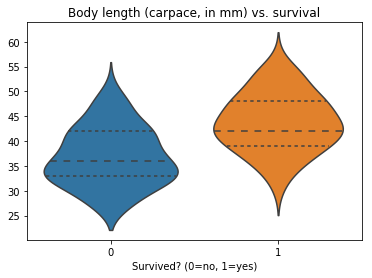

In [5]:
ax = sns.violinplot(x="Survived", y="CarapaceLen",
                    data=df_lobsters, inner="quart")
ax.set(xlabel="Survived? (0=no, 1=yes)",
       ylabel="",
       title="Body length (carpace, in mm) vs. survival");

Although the classes are distinct in the aggregate, where the median carapace (outer shell) length is around 36 mm for the lobsters that died and 42 mm for those that survived, they are not cleanly separable.

## Notation

To develop some intuition and a classification algorithm, let's formulate the general problem and apply it to synthetic data sets.

Let the data consist of $m$ observations of $d$ continuously-valued predictors. In addition, for each data observation we observe a binary label whose value is either 0 or 1.

Just like our convention in the linear regression case, represent each observation, or data point, by an _augumented_ vector, $\hat{x}_i^T$,

$$
\begin{array}{rcl}
  \hat{x}_i^T
    & \equiv &
      \left(\begin{array}{ccccc}
        x_{i,0} &
        x_{i,1} &
         \cdots &
        x_{i,d-1} &
            1
      \end{array}\right)
      .
\end{array}
$$

That is, the point is the $d$ coordinates augmented by an initial dummy coordinate whose value is 1. This convention is similar to what we did in linear regression.

We can also stack these points as rows of a matrix, $X$, again, just as we did in regression:

$$
\begin{array}{rcl}
  X \equiv
    \left(\begin{array}{c}
      \hat{x}_0^T \\
      \hat{x}_1^T \\
      \vdots \\
      \hat{x}_{m-1}^T
    \end{array}\right)
  & = &
    \left(\begin{array}{ccccc}
      x_{0,1} & x_{0,2} & \cdots & x_{0,d} & 1 \\
      x_{1,1} & x_{1,2} & \cdots & x_{1,d} & 1 \\
              &         & \vdots & & 1\\
      x_{m-1,1} & x_{m-1,2} & \cdots & x_{m-1,d} & 1 \\
    \end{array}\right).
\end{array}
$$

We will take the labels to be a binary vector, $y^T \equiv \left(y_0, y_1, \ldots, y_{m-1}\right)^T$.

**Example: A synthetic training set.** We've pre-generated a synthetic data set consisting of labeled data points. Let's download and inspect it, first as a table and then visually.

In [6]:
df = pd.read_csv('{}logreg_points_train.csv'.format(LOCAL_BASE))

display(df.head())
print("...")
display(df.tail())

,x_0,x_1,label
0,-0.234443,-1.075960,1
1,0.730359,-0.918093,0
2,1.432270,-0.439449,0
3,0.026733,1.050300,0
4,1.879650,0.207743,0


...


,x_0,x_1,label
370,1.314300,0.746001,0
371,-0.759737,-0.042944,1
372,0.683560,-0.047791,0
373,0.774747,0.743837,0
374,0.899119,1.576390,0


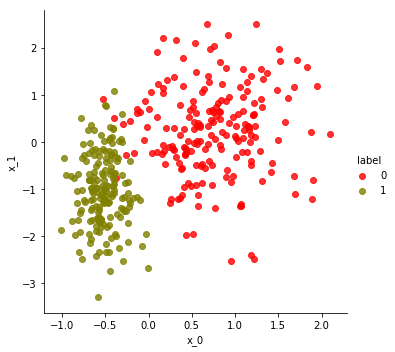

In [7]:
def make_scatter_plot(df, x="x_0", y="x_1", hue="label",
                      palette={0: "red", 1: "olive"},
                      size=5):
    sns.lmplot(x=x, y=y, hue=hue, data=df, palette=palette,
               fit_reg=False)

mpl.rc("savefig", dpi=120) # Adjust for higher-resolution figures
make_scatter_plot(df)

Next, let's extract the coordinates as a Numpy matrix of `points` and the labels as a **Numpy column vector** named `labels`. Mathematically, the `points` matrix corresponds to $X$ and the `labels` vector corresponds to $y$.

> The reason "Numpy column vector" is highlighted is to emphasize that we will store this vector as a 2-D array with one column, as opposed to a 1-D array. Inspect the output below if that isn't clear.

In [8]:
points = np.insert(df[['x_0', 'x_1']].values, 2, 1.0, axis=1)
labels = df['label'].values[:, np.newaxis]

print ("First and last 5 points:\n", '='*23, '\n', points[:5], '\n...\n', points[-5:], '\n')
print ("First and last 5 labels:\n", '='*23, '\n', labels[:5], '\n...\n', labels[-5:], '\n')

First and last 5 points:
 [[-0.234443  -1.07596    1.       ]
 [ 0.730359  -0.918093   1.       ]
 [ 1.43227   -0.439449   1.       ]
 [ 0.0267327  1.0503     1.       ]
 [ 1.87965    0.207743   1.       ]] 
...
 [[ 1.3143     0.746001   1.       ]
 [-0.759737  -0.0429435  1.       ]
 [ 0.68356   -0.0477909  1.       ]
 [ 0.774747   0.743837   1.       ]
 [ 0.899119   1.57639    1.       ]] 

First and last 5 labels:
 [[1]
 [0]
 [0]
 [0]
 [0]] 
...
 [[0]
 [1]
 [0]
 [0]
 [0]] 



## Linear discriminants and the heaviside function

Suppose you think that the _boundary_ between the two clusters may be represented by a line. For the synthetic data example above, I hope you'll agree that such a model is not a terrible one.

A linear boundary is also known as a _linear discriminant_. Any point $x$ on this line may be described by $\theta^T \! x$, where $\theta$ is a vector of coefficients:

$$
\begin{array}{rcl}
  \theta
    & \equiv &
      \left(\begin{array}{c} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_d \end{array}\right)
      .
      \\
\end{array}
$$

For example, suppose our observations have two predictors each ($d=2$). Let the corresponding data point be $x^T \equiv (x_0, x_1, x_2=1.0)$. Then, $\theta^T \! x = 0$ means that

$$
\begin{array}{rrcl}
  &
  \theta^T \! x = 0
  & = & \theta_0 x_0 + \theta_1 x_1 + \theta_2 \\
  \implies
  & x_1
    & = & -\frac{\theta_2}{\theta_1} - \frac{\theta_0}{\theta_1} x_0.
\end{array}
$$

So that describes points _on_ the line. However, given _any_ point $x$ in the $d$-dimensional space that is _not_ on the line, $\theta^T \! x$ still produces a value: that value will be positive on one side of the line ($\theta^T \! x > 0$) or negative on the other ($\theta^T \! x < 0$).

In other words, you can use the linear discriminant function, $\theta^T \! x$, to _generate_ a label for each point $x$: just reinterpret its sign!

If you want "0" and "1" labels, the _heaviside function_, $H(y)$, will convert a positive $y$ to the label "1" and all other values to "0".

$$
\begin{array}{rcl}
  H(y) & \equiv & \left\{\begin{array}{ll}
      1 & \mathrm{if}\ y > 0
      \\
      0 & \mathrm{if}\ y \leq 0
    \end{array}\right..
\end{array}
$$

**Exercise 0** (2 points). Given a $m \times (d+1)$ matrix of augmented points (i.e., the $X$ matrix) and a column vector $\theta$ of length $d+1$, implement a function to compute the value of the linear discriminant at each point. That is, the function should return a (column) vector $y$ where the $y_i = \theta^T \! \hat{x}_i$.

In [9]:
def lin_discr (X, theta):
    return X.dot(theta)

In [10]:
# Test cell: `lin_discr__check`
import random
theta_test = [random.random() for _ in range (3)]
x0_test = [random.random() for _ in range (2)]
x1_test = [(-theta_test[2] - theta_test[0]*x0) / theta_test[1] for x0 in x0_test]
X_test = np.array ([[x0*2 for x0 in x0_test] + [x0*0.5 for x0 in x0_test],
                    x1_test + x1_test,
                    [1.0, 1.0, 1.0, 1.0],]).T
print(X_test, "\n")
LD_test = lin_discr(X_test, np.array([theta_test]).T)
print (LD_test)
dim = np.shape(LD_test)
assert len(dim)==2,"Your function should return a 2-dimensional column vector"
assert dim[0]==len(X_test),"Your length of y is not consistent with the number of observations"
assert dim[1]==1,"Your y is not a column vector"
assert (LD_test[:2] > 0).all ()
assert (LD_test[2:] < 0).all ()
print("\n(Passed.)")

[[ 1.70366258 -1.82657237  1.        ]
 [ 1.26703347 -1.59480112  1.        ]
 [ 0.42591565 -1.82657237  1.        ]
 [ 0.31675837 -1.59480112  1.        ]] 

[[ 0.78860894]
 [ 0.58649754]
 [-0.39430447]
 [-0.29324877]]

(Passed.)


**Exercise 1** (2 points). Implement the _heaviside function_, $H(y)$. Your function should allow for an arbitrary _matrix_ of input values and should apply the heaviside function to each element. In the returned matrix, the elements should have a **floating-point type**.

Example, the code snippet

```python
    A = np.array([[-0.5, 0.2, 0.0],
                  [4.2, 3.14, -2.7]])
    print(heaviside(A))
```

should display

```
    [[ 0.  1.  0.]
     [ 1.  1.  0.]]
```

> There are several possible approaches that lead to one-line solutions. One uses only logical and arithmetic operators, which you will recall are implemented as elementwise operations for Numpy arrays. Another uses Numpy's [`sign()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.sign.html) function.

In [11]:
def heaviside(Y):
    return 1. * (Y > 0)

In [12]:
# Test cell: `heaviside__check`

Y_test = np.array([[-2.3, 1.2, 7.],
                   [0.0, -np.inf, np.inf]])
H_Y_test = heaviside(Y_test)

print("Y:\n", Y_test)
print("\nH(Y):\n", H_Y_test)

assert (H_Y_test.astype(int) == np.array([[0, 1, 1], [0, 0, 1]])).all ()

print ("\n(Passed.)")

Y:
 [[-2.3  1.2  7. ]
 [ 0.  -inf  inf]]

H(Y):
 [[0. 1. 1.]
 [0. 0. 1.]]

(Passed.)


For the next exercise, we'll need the following functions.

In [13]:
def heaviside_int(Y):
    """Evaluates the heaviside function, but returns integer values."""
    return heaviside(Y).astype(dtype=int)

def gen_lin_discr_labels(points, theta, fun=heaviside_int):
    """
    Given a set of points and the coefficients of a linear
    discriminant, this function returns a set of labels for
    the points with respect to this discriminant.
    """
    score = lin_discr(points, theta)
    labels = fun(score)
    return labels

def plot_lin_discr(theta, df, x="x_0", y="x_1", hue="label",
                   palette={0: "red", 1: "olive"}, size=5,
                   linewidth=2):
    lm = sns.lmplot(x=x, y=y, hue=hue, data=df, palette=palette,
                    size=size, fit_reg=False)
    
    x_min, x_max = df[x].min(), df[x].max()
    y_min, y_max = df[y].min(), df[y].max()
    
    x1_min = (-theta[2][0] - theta[0][0]*x_min) / theta[1][0]
    x1_max = (-theta[2][0] - theta[0][0]*x_max) / theta[1][0]
    plt.plot([x_min, x_max], [x1_min, x1_max], linewidth=linewidth)
    
    def expand_interval(x_limits, percent=10.0):
        x_min, x_max = x_limits[0], x_limits[1]
        if x_min < 0:
            x_min *= 1.0 + 1e-2*percent
        else:
            x_min *= 1.0 - 1e-2*percent
        if x_max > 0:
            x_max *= 1.0 + 1e-2*percent
        else:
            x_max *= 1.0 + 1e-2*percent
        return (x_min, x_max)
    x_view = expand_interval((x_min, x_max))
    y_view = expand_interval((y_min, y_max))
    lm.axes[0,0].set_xlim(x_view[0], x_view[1])
    lm.axes[0,0].set_ylim(y_view[0], y_view[1])
    
def mark_matches(a, b, exact=False):
    """
    Given two Numpy arrays of {0, 1} labels, returns a new boolean
    array indicating at which locations the input arrays have the
    same label (i.e., the corresponding entry is True).
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as the same up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    assert a.shape == b.shape, "a.shape ({}) does not match b.shape ({})".format(a.shape, b.shape)
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1)).all()
    assert ((b_int == 0) | (b_int == 1)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod(a.shape):
        return exact_matches
    return exact_matches == False # Invert
    
def count_matches(a, b, exact=False):
    """
    Given two sets of {0, 1} labels, returns the number of mismatches.
    
    This function can consider "inexact" matches. That is, if `exact`
    is False, then the function will assume the {0, 1} labels may be
    regarded as similar up to a swapping of the labels. This feature
    allows
    
      a == [0, 0, 1, 1, 0, 1, 1]
      b == [1, 1, 0, 0, 1, 0, 0]
      
    to be regarded as equal. (That is, use `exact=False` when you
    only care about "relative" labeling.)
    """
    matches = mark_matches(a, b, exact=exact)
    return int(matches.sum())

**Exercise 2** (2 points). For the synthetic data you loaded above, try by hand to find a value for $\theta$ such that $H(\theta^T x)$ "best" separates the two clusters. Store this $\theta$ in a variable named `my_theta`, which should be a Numpy _column vector_. That is, define `my_theta` here using a line like:

```python
my_theta = np_col_vec([3., 0., -1.])
```

where `np_col_vec` is defined below and the list of values are your best guesses at discriminating coefficients. The test code will check that your solution makes no more than ten misclassifications.

> Hint: We found a set of coefficients that commits just 5 errors for the 375 input points.

In [14]:
def np_col_vec (list_values):
    """Returns a Numpy column vector for the given list of scalar values."""
    return np.array ([list_values]).T

# Redefine `my_theta` as instructed above to reduce the number of mismatches:
my_theta = np_col_vec([-1., 3., 0.]) # 123 mismatches

# m = theta_0/theta_1, b = theta_2
my_theta = np_col_vec([0., 1., 0.]) # 93 mismatches
my_theta = np_col_vec([1., 1., 0.]) # 39 mismatches
my_theta = np_col_vec([2., 1., 0.]) # 23 mismatches
my_theta = np_col_vec([3., 1., 0.]) # 15 mismatches
my_theta = np_col_vec([4., 1., 0.]) # 12 mismatches
my_theta = np_col_vec([5., 1., 0.]) # 11 mismatches
my_theta = np_col_vec([6., 1., 0.]) # 11 mismatches
my_theta = np_col_vec([6., 1., 1.]) # 6 mismatches
my_theta = np_col_vec([6., 1., 1.5]) # 6 mismatches

Detected 6 out of 375 mismatches.


/usr/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


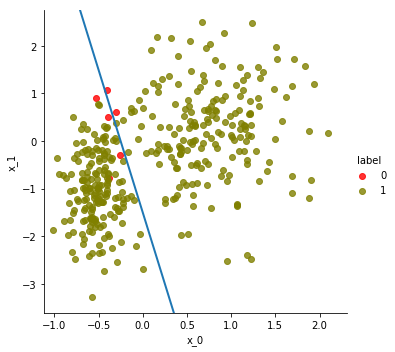

In [15]:
# Here are the labels generated by your discriminant:
my_labels = gen_lin_discr_labels(points, my_theta)

# Here is a visual check:
num_mismatches = len(labels) - count_matches(labels, my_labels)
print ("Detected", num_mismatches, "out of", len(labels), "mismatches.")

df_matches = df.copy ()
df_matches['label'] = mark_matches (my_labels, labels).astype (dtype=int)

mpl.rc("savefig", dpi=100) # Adjust for higher-resolution figures
plot_lin_discr (my_theta, df_matches)

assert num_mismatches <= 10

**How the heaviside divides the space.** The heaviside function, $H(\theta^T x)$, enforces a sharp boundary between classes around the $\theta^T x=0$ line. The following code produces a [contour plot](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.contourf.html) to show this effect: there will be a sharp dividing line between 0 and 1 values, with one set of values shown as a solid dark area and the remaining as a solid light-colored area.

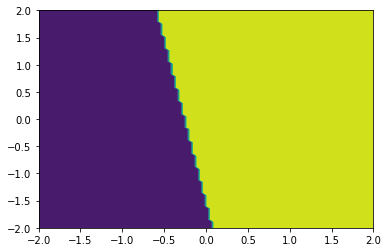

In [16]:
x0 = np.linspace(-2., +2., 100)
x1 = np.linspace(-2., +2., 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
h_grid = heaviside(my_theta[2] + my_theta[0]*x0_grid + my_theta[1]*x1_grid)
plt.contourf(x0, x1, h_grid)

# Part 1: The logistic (or sigmoid) function as an alternative discriminant

As the lobsters example suggests, real data are not likely to be cleanly separable, especially when the number of features we have at our disposal is relatively small.

Since the labels are 0 or 1, you could look for a way to interpret labels as _probabilities_ rather than as hard (0 or 1) labels. One such function is the _logistic function_, also referred to as the _logit_ or [_sigmoid_](https://en.wikipedia.org/wiki/Sigmoid_function) function.

$$
\begin{array}{rcl}
  G(y) & \equiv & \dfrac{1}{1 + e^{-y}}
\end{array}
$$

The logistic function takes any value in the domain $(-\infty, +\infty)$ and produces a value in the range $(0, 1)$. Thus, given a value $y$, we can interpret $G(y)$ as a conditional probability that the label is 1 given $y$, i.e., $G(y) \equiv \mathrm{Pr}[\mbox{label is }1 \,|\, y]$.

**Exercise 3** (2 points). Implement the logistic function. Inspect the resulting plot of $G(y)$ in 1-D and then the contour plot of $G(\theta^T{x})$. Your function should accept a Numpy matrix of values, `Y`, and apply the sigmoid elementwise.

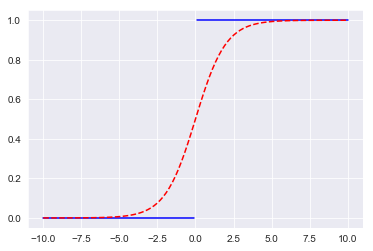

In [17]:
def logistic(Y):
    return 1 / (1 + np.exp(-Y))
    
# Plot your function for a 1-D input.
y_values = np.linspace(-10, 10, 100)

mpl.rc("savefig", dpi=120) # Adjust for higher-resolution figures
sns.set_style("darkgrid")
y_pos = y_values[y_values > 0]
y_rem = y_values[y_values <= 0]
plt.plot(y_rem, heaviside (y_rem), 'b')
plt.plot(y_pos, heaviside (y_pos), 'b')
plt.plot(y_values, logistic (y_values), 'r--')
#sns.regplot (y_values, heaviside (y_values), fit_reg=False)
#sns.regplot (y_values, logistic (y_values), fit_reg=False)


(Passed.)


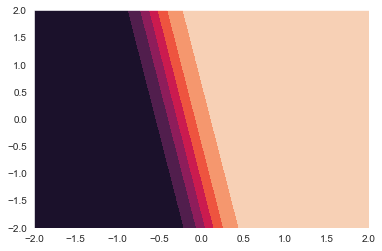

In [18]:
# Test cell: `logistic__check`

assert logistic(np.log(3)) == 0.75
assert logistic(-np.log(3)) == 0.25

g_grid = logistic(my_theta[2] + my_theta[0]*x0_grid + my_theta[1]*x1_grid)
plt.contourf (x0, x1, g_grid)
assert ((np.round(g_grid) - h_grid).astype(int) == 0).all()

print ("\n(Passed.)")

**Exercise 4** (_optional_; ungraded). Consider a set of 1-D points generated by a _mixture of Gaussians_. That is, suppose that there are two Gaussian distributions over the 1-dimensional variable, $x \in (-\infty, +\infty)$, that have the _same_ variance ($\sigma^2$) but _different_ means ($\mu_0$ and $\mu_1$). Show that the conditional probability of observing a point labeled "1" given $x$ may be written as,

$$\mathrm{Pr}\left[l=1\,|\,x\right]
    \propto \dfrac{1}{1 + e^{-(\theta_0 x + \theta_1)}},$$

for a suitable definition of $\theta_0$ and $\theta_1$.

_Hints._ Since the points come from Gaussian distributions,

$$
\begin{eqnarray}
  \mathrm{Pr}\left[x \, | \, l\right]
    & \equiv & \dfrac{1}{\sigma \sqrt{2 \pi}} \exp \left(-\frac{(x - \mu_l)^2}{2 \sigma^2}\right).
\end{eqnarray}
$$

To rewrite $\mathrm{Pr}\left[l\,|\,x\right]$ in terms of $\mathrm{Pr}\left[x \, | \, l\right]$, recall _Bayes's rule_ (also: [Bayes's theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)):

$$
\begin{eqnarray}
  \mathrm{Pr}[l=1\,|\,x]
    & = &
      \dfrac{\mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1]}
            {\mathrm{Pr}[x]},
\end{eqnarray}
$$

where the denominator can be expanded as

$$
\begin{eqnarray}
  \mathrm{Pr}[x] & = & \mathrm{Pr}[x\,|\,l=0] \, \mathrm{Pr}[l=0] + \mathrm{Pr}[x\,|\,l=1] \, \mathrm{Pr}[l=1].
\end{eqnarray}
$$

You may assume the prior probabilities of observing a 0 or 1 are given by $\mathrm{Pr}[l=0] \equiv p_0$ and $\mathrm{Pr}[l=1] \equiv p_1$.

> The point of this derivation is to show you that the definition of the logistic function does not just arise out of thin air. It also hints that you might expect a final algorithm for logistic regression based on using $G(y)$ as the discriminant will work well when the classes are best explained as a mixture of Gaussians.

**Generalizing to $d$-dimensions.** The preceding exercise can be generalized to $d$-dimensions. Let $\theta$ and $x$ be $(d+1)$-dimensional points. Then,

$$
\begin{eqnarray}
  \mathrm{Pr}\left[l=1\,|\,x\right]
    & \propto & \dfrac{1}{1 + \exp \left( -\theta^T \! x \right)}.
\end{eqnarray}
$$

**Exercise 5** (_optional_; ungraded). Verify the following properties of the logistic function, $G(y)$.

$$
\begin{array}{rcll}
  G(y)
    & = & \frac{e^y}{e^y + 1}
    & \mathrm{(P1)} \\
  G(-y)
    & = & 1 - G(y)
    & \mathrm{(P2)} \\
  \dfrac{dG}{dy}
    & = & G(y) G(-y)
    & \mathrm{(P3)} \\
  {\dfrac{d}{dy}} {\left[ \ln G(y) \right]}
    & = & G(-y)
    & \mathrm{(P4)} \\
  {\dfrac{d}{dy}} {\ln \left[ 1 - G(y) \right]}
    & = & -G(y)
    & \mathrm{(P5)}
\end{array}
$$

**Answers.** In all of the derivations below, we use the fact that $G(y) > 0$.

_(P1)_. Multiply the numerator and denominator by $e^y$.

_(P2)_. Start with the right-hand side, $1 - G(y)$, apply some algebra, and then apply (P1).

$$
  1 - G(y)
  = \dfrac{e^y + 1}
          {e^y + 1}
    - \dfrac{e^y}
            {e^y + 1}
  = \dfrac{1}{e^y + 1} \cdot \dfrac{e^{-y}}{e^{-y}}
  = \dfrac{e^{-y}}{e^{-y} + 1}
  = G(-y).
$$

_(P3)_. By direct calculation and application of (P1):

$$
  \dfrac{dG}{dy}
  = \dfrac{d}{dy}\left( 1 + e^{-y} \right)^{-1}
  = - \left( 1 + e^{-y} \right)^{-2} \cdot (-e^{-y})
  = \underbrace{\dfrac{1}{1 + e^{-y}}}_{= G(y)} \cdot \underbrace{\dfrac{e^{-y}}{1 + e^{-y}}}_{= G(-y)}
  = G(y) \cdot G(-y).
$$

_(P4)_. By the chain rule and application of (P3):

$$
  \dfrac{d}{dy} \ln G(y)
  = \left(\dfrac{d}{dG} \ln G\right) \dfrac{dG}{dy}
  = \dfrac{1}{G(y)} \cdot G(y) G(-y)
  = G(-y).
$$

_(P5)_. By combining (P2), variable substitution and the chain rule, and (P4),

$$
  \dfrac{d}{dy} \ln \left[ 1 - G(y) \right]
  = \dfrac{d}{dy} \ln G(-y)
  = \underbrace{ \left[ \dfrac{d}{dz} \ln G(z) \right] \cdot \dfrac{dz}{dy} }_{ \mbox{Let } z \equiv -y}
  = G(-z) \cdot (-1)
  = -G(y).
$$

## Part 2: Determining the discriminant via maximum likelihood estimation

Previously, you determined $\theta$ for our synthetic dataset by hand. Can you compute a good $\theta$ automatically? One of the standard techniques in statistics is to perform a _maximum likelihood estimation_ (MLE) of a model's parameters, $\theta$. Indeed, you may have seen or used MLE to derive the normal equations for linear regression in a more "statistically principled" way than what we did in Notebook 12.

**"Likelihood" as an objective function.** MLE derives from the following idea. Consider the joint probability of observing all of the labels, given the points and the parameters, $\theta$:

$$
  \mathrm{Pr}[y\,|\,X, \theta].
$$

Suppose these observations are independent and identically distributed (i.i.d.). Then the joint probability can be factored as the product of individual probabilities,

$$
\begin{eqnarray}
  \mathrm{Pr}[y\, | \,X, \theta] = \mathrm{Pr}[y_0, \ldots, y_{m-1} \,|\, \hat{x}_0, \ldots, \hat{x}_{m-1}, \theta]
  & = & \mathrm{Pr}[y_0 \,|\, \hat{x}_0, \theta] \cdots \mathrm{Pr}[y_{m-1} \,|\, \hat{x}_{m-1}, \theta] \\
  & = & \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta].
\end{eqnarray}
$$

The _maximum likelihood principle_ says that you should choose $\theta$ to maximize the chances (or "likelihood") of seeing these particular observations. Thus, $\mathrm{Pr}[y\, | \,X, \theta]$ is now an objective function to maximize.

For both mathematical and numerical reasons, we will use the _logarithm_ of the likelihood, or _log-likelihood_, as the objective function instead. Let's define it as

$$
\begin{eqnarray}
  \mathcal{L}(\theta; y, X)
    & \equiv &
      \log \left\{ \displaystyle \prod_{i=0}^{m-1} \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta] \right\} \\
    & = &
      \displaystyle \sum_{i=0}^{m-1} \log \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta].
\end{eqnarray}
$$

> _Note._ We are using the symbol $\log$, which could be taken in any convenient base, such as the natural logarithm ($\ln y$) or the information theoretic base-two logarithm ($\log_2 y$).
>
> _Follow-up question._ Above, we wrote that we would want to log-transform the objective function for "mathematical and numerical reasons." What is the mathematical reason? What is the numerical reason?

The MLE fitting procedure then consists of two steps:

* For the problem at hand, decide on a model of $\mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta]$.
* Run any optimization procedure to find the $\theta$ that maximizes $\mathcal{L}(\theta; y, X)$.

# Part 3: MLE for logistic regression

Let's say you have decided that the logistic function, $G(\hat{x}_i^T \theta) = G(\theta^T \hat{x}_i)$, is a good model of the probability of producing a label $y_i$ given the observation $\hat{x}_i^T$. Under the i.i.d. assumption, you can interpret the label $y_i$ as the result of flipping a coin, or a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial), where the probability of success ($y_i=1$) is defined as $g_i = g_i(\theta) \equiv G(\hat{x}_i^T \theta)$. Thus,

$$
\begin{eqnarray}
  \mathrm{Pr}[y_i \,|\, \hat{x}_i, \theta]
    & \equiv & g_i^{y_i} \cdot \left(1 - g_i\right)^{1 - y_i}.
\end{eqnarray}
$$

The log-likelihood in turn becomes,

$$
\begin{eqnarray}
  \mathcal{L}(\theta; y, X)
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \ln g_i + (1-y_i) \ln (1-g_i) \\
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \ln \dfrac{g_i}{1-g_i} + \ln (1-g_i) \\
    & = & \displaystyle
      \sum_{i=0}^{m-1} y_i \theta^T \hat{x}_i + \ln (1-g_i).
\end{eqnarray}
$$

You can write the log-likelihood more compactly in the language of linear algebra.

**Convention 1.** Let $u \equiv (1, \ldots, 1)^T$ be a column vector of all ones, with its length inferred from context. Let $A = \left(\begin{array}{cccc} a_0 & a_1 & \cdots & a_{n-1} \end{array}\right)$ be any matrix, where $\{a_i\}$ denote its $n$ columns. Then, the sum of the columns is a matrix-vector product between $A$ and $u$:

$$\sum_{i=0}^{n-1} a_i
  = \left(a_0\ a_1\ \cdots\ a_{n-1}\right)
      \cdot \left(\begin{array}{c}
              1 \\
              1 \\
              \vdots \\
              1
            \end{array}\right)
  = A u.
$$

**Convention 2.** Let $A = \left(a_{ij}\right)$ be any matrix and let $f(z)$ be any function that we have defined by default to accept a scalar argument $z$ and produce a scalar result. For instance, $f(z) = \ln z$ or $f(z) = G(z)$. Then, assume that $B = f(A)$ applies $f(\cdot)$ to $A$ **elementwise**: that is, each $b_{ij} = f(a_{ij})$.

With these notational conventions, convince yourself that these are two different ways to write the log-likelihood for logistic regression.

$$
\begin{array}{rrcl}
  (\mathrm{V1}) & \mathcal{L}(\theta; y, X) & = & y^T \ln G(X \theta) + (u-y)^T \ln [u - G(X \theta)] \\
  (\mathrm{V2}) & \mathcal{L}(\theta; y, X) & = & y^T X \theta + u^T \ln G(-X \theta)
\end{array}
$$

**Exercise 6** (2 points). Implement the log-likelihood function in Python by defining a function with the following signature:

```python
  def log_likelihood (theta, y, X):
    ...
```

> To compute the elementwise logarithm of a matrix or vector, use Numpy's [`log`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) function.

In [19]:
def log_likelihood(theta, y, X):
    # (V2) 
    return y.T.dot(X.dot(theta)) + np.ones(y.shape[0]).dot(np.log(logistic(-X.dot(theta))))

In [20]:
# Test cell: `log_likelihood__check`

if False:
    d_soln = 10
    m_soln = 1000
    theta_soln = np.random.random ((d_soln+1, 1)) * 2.0 - 1.0
    y_soln = np.random.randint (low=0, high=2, size=(m_soln, 1))
    X_soln = np.random.random ((m_soln, d_soln+1)) * 2.0 - 1.0
    X_soln[:, 0] = 1.0
    L_soln = log_likelihood (theta_soln, y_soln, X_soln)
    np.savez_compressed('log_likelihood_soln',
                        d_soln, m_soln, theta_soln, y_soln, X_soln, L_soln)

npzfile_soln = np.load('{}log_likelihood_soln.npz'.format(LOCAL_BASE))
d_soln = npzfile_soln['arr_0']
m_soln = npzfile_soln['arr_1']
theta_soln = npzfile_soln['arr_2']
y_soln = npzfile_soln['arr_3']
X_soln = npzfile_soln['arr_4']
L_soln = npzfile_soln['arr_5']

L_you = log_likelihood(theta_soln, y_soln, X_soln)
your_err = np.max(np.abs(L_you/L_soln - 1.0))
display(Math(r'\left\|\dfrac{\mathcal{L}_{\tiny \mbox{yours}} - \mathcal{L}_{\tiny \mbox{solution}}}{\mathcal{L}_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_err))
assert your_err <= 1e-12

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


# Part 4: Computing the MLE solution via gradient ascent: theory

To optimize the log-likelihood with respect to the parameters, $\theta$, you want to "set the derivative to zero" and solve for $\theta$.

For example, recall that in the case of linear regression via least squares minimization, carrying out this process produced an _analytic_ solution for the parameters, which was to solve the normal equations.

Unfortunately, for logistic regression---or for most log-likelihoods you are likely to ever write down---you _cannot_ usually derive an analytic solution. Therefore, you will need to resort to numerical optimization procedures.

**Gradient ascent, in 1-D.** A simple numerical algorithm to maximize a function is _gradient ascent_ (or _steepest ascent_). If instead you are minimizing the function, then the equivalent procedure is gradient (or steepest) _descent_. Here is the basic idea in 1-D.

Suppose we wish to find the maximum of a scalar function $f(x)$ in one dimension. At the maximum, $\dfrac{df(x)}{dx} = 0$.

Suppose instead that $\dfrac{df}{dx} \neq 0$ and consider the value of $f$ at a nearby point, $x + s$, as given approximately by a truncated Taylor series:

$$
\begin{eqnarray}
  f(x + s)
    & = &
      f(x) + s \dfrac{df(x)}{dx} + \mathcal{O}(s^2).
\end{eqnarray}
$$

To make progress toward maximizing $f(x)$, you'd like to choose $s$ so that $f(x+s) > f(x)$. One way is to choose $s=\alpha \cdot \mathrm{sign} \left(\dfrac{df}{dx}\right)$, where $0 < \alpha \ll 1$ is "small:"

$$
\begin{eqnarray}
  f \left(x + \alpha \cdot \mathrm{sign} \left(\dfrac{df}{dx}\right) \right)
    & \approx &
      f(x) + \alpha \left|\dfrac{df}{dx}\right| + \mathcal{O}(\alpha^2).
\end{eqnarray}
$$

If $\alpha$ is small enough, then you can neglect the $\mathcal{O}(\alpha^2)$ term and $f(x + s)$ will be larger than $f(x)$, thus making progress toward finding a maximum.

This scheme is the basic idea: starting from some initial guess $x$, refine the guess by taking a small step $s$ _in the direction_ of the derivative, i.e., $\mathrm{sign} \left(\dfrac{df}{dx}\right)$.

**Gradient ascent in higher dimensions.** Now suppose $x$ is a vector rather than a scalar. Now consider a nearby point, $x + s$, where $s$ is a _vector_. Then $f(x + s)$ becomes

$$
\begin{eqnarray}
  f(x + s) = f(x) + s^T \nabla_x f(x) + \mathcal{O}(\|s\|^2),
\end{eqnarray}
$$

where $\nabla_x f(x)$ is the gradient of $f$ with respect to $x$. As in the 1-D case, you want a step $s$ such that $f(x + s) > f(x)$. To make as much progress as possible, let's choose $s$ to be parallel to $\nabla_x\,f(x)$, that is, proportional to the gradient:

$$
\begin{eqnarray}
  s \equiv \alpha \dfrac{\nabla_x\,f(x)}{\|\nabla_x\,f(x)\|}.
\end{eqnarray}
$$

Again, $\alpha$ is a fudge (or "gentle nudge?") factor. You need to choose it to be small enough that the high-order terms of the Taylor approximation become negligible, yet large enough that you can make reasonable progress.

**The gradient ascent procedure applied to MLE.** Applying gradient ascent to the problem of maximizing the log-likelihood leads to the following algorithm.

* Start with some initial guess, $\theta(0)$.
* At each iteration $t \geq 0$ of the procedure, let $\theta(t)$ be the current guess.
* Compute the direction of steepest ascent by evaluating the gradient, $\Delta_t \equiv \nabla_{\theta(t)} \left\{\mathcal{L}(\theta(t); y, X)\right\}$.
* Define the step to be $s_t \equiv \alpha \dfrac{\Delta_t}{\|\Delta_t\|}$, where $\alpha$ is a suitably chosen fudge factor.
* Take a step in the direction of the gradient, $\theta(t+1) \leftarrow \theta(t) + s_t$.
* Stop when the parameters don't change much _or_ after some maximum number of steps.

This procedure should remind you of the LMS algorithm for (online) regression. As was true then, the tricky bit is how to choose $\alpha$.

> There is at least one difference between this procedure and the online regression procedure you learned earlier. Here, we are optimizing using the _full_ dataset rather than processing data points one at a time. (That is, the step iteration variable $t$ used above is not used in exactly the same way as the step iteration in LMS.)
>
> Another question is, how do we know this procedure will converge to the global maximum, rather than, say, a local maximum? For that you need a deeper analysis of a specific $\mathcal{L}(\theta; y, X)$, to show, for instance, that it is convex in $\theta$.

## Implementing logistic regression using MLE by gradient ascent

Let's apply the gradient ascent procedure to the logistic regression problem, in order to determine a good $\theta$.

**Exercise 7** (_optional_; ungraded). Show the following.

$$
\begin{eqnarray}
  \nabla_\theta \left\{\mathcal{L}(\theta; y, X)\right\}
    & = & X^T \left[ y - G(X \cdot \theta)\right].
\end{eqnarray}
$$

**Answer.** From (V2),

$$
  \mathcal{L}(\theta; y, X) = y^T X \theta + u^T \ln G(-X \theta).
$$

Thus,

$$
  \nabla_\theta \{\mathcal{L}(\theta; y, X)\}
  = \nabla_\theta (y^T X \theta)
    + \nabla_\theta \left( u^T \ln G(-X \theta) \right).
$$

Let's consider each term in turn.

For the first term, apply the gradient identities to obtain

$$
\begin{eqnarray}
  \nabla_\theta \, (y^T X \theta) & = & \nabla_\theta \, (\theta^T X^T y) = X^T y.
\end{eqnarray}
$$

For the second term, recall the scalar interpretation of $u^T \ln G(-X \theta)$.

$$
\begin{eqnarray}
  u^T \ln G(-X \theta)
  & = & \sum_{j=0}^{m-1} \ln G\left(-\hat{x}_j^T \theta\right).
\end{eqnarray}
$$

The $i$-th component of the gradient is

$$
\begin{eqnarray}
  \dfrac{\partial}{\partial \theta_i} \sum_{j=0}^{m-1} \ln G\left(-\hat{x}_j^T \theta\right)
  & = & \sum_{j=0}^{m-1} \dfrac{\partial}{\partial \theta_i} \ln G\left(-\hat{x}_j^T \theta\right).
\end{eqnarray}
$$

Let's evaluate the summand:

$$
\dfrac{\partial}{\partial \theta_i} \ln G\left(-\hat{x}_j^T \theta\right)
= \underbrace{\left[ \dfrac{d}{dz} \ln G(z) \right] \cdot \left[ \dfrac{\partial z}{\partial \theta_i} \right]}_{\mbox{Let } z \, \equiv \, -\hat{x}_j^T \theta}
= G(-z) \cdot \dfrac{\partial}{\partial \theta_i} \left(-\hat{x}_j^T \theta\right)
= - G\left(\hat{x}_j^T \theta\right) \cdot x_{ji}.
$$

Thus, the $i$-th component of the gradient becomes

$$
  \left[\nabla_\theta \left( u^T \ln G(-X \theta) \right)\right]_i
  = - \sum_{j=0}^{m-1} G\left(\hat{x}_j^T \theta\right) \cdot x_{ji}.
$$

In other words, the full gradient vector is

$$
  \nabla_\theta \left( u^T \ln G(-X \theta) \right)
  = -X^T G(X \theta).
$$

Putting the two components together,

$$
  \nabla_\theta \{\mathcal{L}(\theta; y, X)\}
  = X^T y - X^T G(X \theta)
  = X^T \left[ y - G(X \theta) \right].
$$

**Exercise 8** (2 points). Implement a function to compute the gradient of the log-likelihood. Your function should have the signature,

```python
  def grad_log_likelihood (theta, y, X):
      ...
```

In [21]:
def grad_log_likelihood(theta, y, X):
    """Returns the gradient of the log-likelihood."""
    return X.T.dot(y - logistic(X.dot(theta)))

In [22]:
# Test cell: `grad_log_likelihood_code__check`

if False:
    d_grad_soln = 6
    m_grad_soln = 399
    theta_grad_soln = np.random.random((d_grad_soln+1, 1)) * 2.0 - 1.0
    y_grad_soln = np.random.randint(low=0, high=2, size=(m_grad_soln, 1))
    X_grad_soln = np.random.random((m_grad_soln, d_grad_soln+1)) * 2.0 - 1.0
    X_grad_soln[:, 0] = 1.0
    L_grad_soln = grad_log_likelihood(theta_grad_soln, y_grad_soln, X_grad_soln)
    np.savez_compressed('grad_log_likelihood_soln',
                        d_grad_soln, m_grad_soln, theta_grad_soln, y_grad_soln, X_grad_soln, L_grad_soln)

npzfile_grad_soln = np.load ('{}grad_log_likelihood_soln.npz'.format(LOCAL_BASE))
d_grad_soln = npzfile_grad_soln['arr_0']
m_grad_soln = npzfile_grad_soln['arr_1']
theta_grad_soln = npzfile_grad_soln['arr_2']
y_grad_soln = npzfile_grad_soln['arr_3']
X_grad_soln = npzfile_grad_soln['arr_4']
L_grad_soln = npzfile_grad_soln['arr_5']

L_grad_you = grad_log_likelihood (theta_grad_soln, y_grad_soln, X_grad_soln)
your_grad_err = np.max (np.abs (L_grad_you/L_grad_soln - 1.0))
display (Math (r'\left\|\dfrac{\nabla\, \mathcal{L}_{\tiny \mbox{yours}} - \nabla\,\mathcal{L}_{\tiny \mbox{solution}}}{\nabla\, \mathcal{L}_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_grad_err))
assert your_grad_err <= 1e-12

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


**Exercise 9** (4 points). Implement the gradient ascent procedure to determine $\theta$, and try it out on the sample data.

Recall the procedure (repeated from above):
* Start with some initial guess, $\theta(0)$.
* At each iteration $t \geq 0$ of the procedure, let $\theta(t)$ be the current guess.
* Compute the direction of steepest ascent by evaluating the gradient, $\Delta_t \equiv \nabla_{\theta(t)} \left\{\mathcal{L}(\theta(t); y, X)\right\}$.
* Define the step to be $s_t \equiv \alpha \dfrac{\Delta_t}{\|\Delta_t\|}$, where $\alpha$ is a suitably chosen fudge factor.
* Take a step in the direction of the gradient, $\theta(t+1) \leftarrow \theta(t) + s_t$.
* Stop when the parameters don't change much _or_ after some maximum number of steps.

In the code skeleton below, we've set up a loop to run a fixed number, `MAX_STEP`, of gradient ascent steps. Also, when normalizing the step $\Delta_t$, use the two-norm.

> In your solution, we'd like you to store *all* guesses in the matrix `thetas`, so that you can later see how the $\theta(t)$ values evolve. To extract a particular column `t`, use the notation, `theta[:, t:t+1]`. This notation is necessary to preserve the "shape" of the column as a column vector.

Your (hand) solution: [6.  1.  1.5]
Computed solution: [-15.58288018  -3.03395005  -3.81810021]

=== Comparisons ===


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [4.] , vs. MLE (via gradient ascent), which is [4.08131775]


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [0.66666667] , vs. MLE (via gradient ascent), which is [0.79462295]

=== The MLE solution, visualized ===


/usr/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


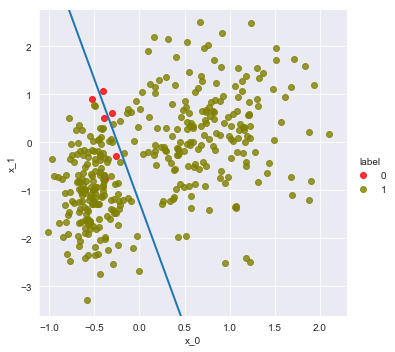

In [23]:
ALPHA = 0.1
MAX_STEP = 250

# Get the data coordinate matrix, X, and labels vector, y
X = points
y = labels.astype(dtype=float)

# Store *all* guesses, for subsequent analysis
thetas = np.zeros((3, MAX_STEP+1))

for t in range(MAX_STEP):
    # Fill in the code to compute thetas[:, t+1:t+2]
    from numpy.linalg import norm
    theta = thetas[:, t:t+1]
    theta_grad = grad_log_likelihood(theta, y, X)
    s_t = ALPHA * theta_grad / norm(theta_grad)
    thetas[:, t+1:t+2] = theta + s_t
    
theta_ga = thetas[:, MAX_STEP:]
print("Your (hand) solution:", my_theta.T.flatten())
print("Computed solution:", theta_ga.T.flatten())

print("\n=== Comparisons ===")
display(Math (r'\dfrac{\theta_0}{\theta_2}:'))
print("Your manual (hand-picked) solution is", my_theta[0]/my_theta[2], \
      ", vs. MLE (via gradient ascent), which is", theta_ga[0]/theta_ga[2])
display(Math (r'\dfrac{\theta_1}{\theta_2}:'))
print("Your manual (hand-picked) solution is", my_theta[1]/my_theta[2], \
      ", vs. MLE (via gradient ascent), which is", theta_ga[1]/theta_ga[2])

print("\n=== The MLE solution, visualized ===")
ga_labels = gen_lin_discr_labels(points, theta_ga)
df_ga = df.copy()
df_ga['label'] = mark_matches(ga_labels, labels).astype (dtype=int)
plot_lin_discr(theta_ga, df_ga)

In [24]:
print ("\n=== Mismatch counts ===")

my_labels = gen_lin_discr_labels (points, my_theta)
my_mismatches = len (labels) - count_matches (labels, my_labels)
print ("Your manual (hand-picked) solution has", num_mismatches, "mismatches.")

ga_labels = gen_lin_discr_labels (points, theta_ga)
ga_mismatches = len (labels) - count_matches (labels, ga_labels)
print ("The MLE method produces", ga_mismatches, "mismatches.")

assert ga_mismatches <= 8
print ("\n(Passed.)")


=== Mismatch counts ===
Your manual (hand-picked) solution has 6 mismatches.
The MLE method produces 6 mismatches.

(Passed.)


**The gradient ascent trajectory.** Let's take a look at how gradient ascent progresses. (You might try changing the $\alpha$ parameter and see how it affects the results.)

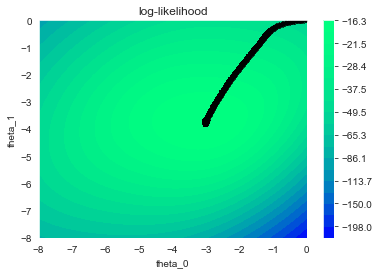

In [25]:
n_ll_grid = 100
x1 = np.linspace(-8., 0., n_ll_grid)

x2 = np.linspace(-8., 0., n_ll_grid)
x1_grid, x2_grid = np.meshgrid(x1, x2)

ll_grid = np.zeros((n_ll_grid, n_ll_grid))
for i1 in range(n_ll_grid):
    for i2 in range(n_ll_grid):
        theta_i1_i2 = np.array([[thetas[0, MAX_STEP]],
                                [x1_grid[i1][i2]],
                                [x2_grid[i1][i2]]])
        ll_grid[i1][i2] = log_likelihood(theta_i1_i2, y, X)

# Determine a color scale
def v(x):
    return -np.log(np.abs(x))
    return x

def v_inv(v):
    return -np.exp(np.abs(v))
    return v

v_min, v_max = v(ll_grid.min()), v(ll_grid.max())
v_range = v_max - v_min
v_breaks = v_inv(np.linspace(v_min, v_max, 20))

p = plt.contourf(x1, x2, ll_grid, v_breaks, cmap=plt.cm.get_cmap("winter"))
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('log-likelihood')
plt.colorbar()
plt.plot(thetas[1, :], thetas[2, :], 'k*-')

# Part 5 (optional): Numerical optimization via Newton's method

The fudge factor, $\alpha$, in gradient ascent should give you pause. Can you choose the step size or direction in a better or more principled way?

One idea is [_Newton's method_](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization), summarized below.

> This part of the notebook has additional exercises, but they are all worth 0 points. (So if you submit something that is incomplete or fails the test cells, you won't lose any points.)

**The basic idea, in 1-D.** Suppose you start at a point $x$ and you have decided to take a step of size $s$. That puts you at $f(x + s)$.

How do you choose $s$ to make progress toward reaching a maximum? In gradient ascent, you do so by following the gradient, which points in an "upward" direction.

In Newton's method, you will pick $s$ in a different way: choose $s$ to maximize $f(x + s)$.

That should strike you as circular; the whole problem from the beginning was to maximize $f(x)$. The trick, in this case, is not to maximize $f(x+s)$ directly; rather, let's replace it with some approximation, $q(s) \approx f(x+s)$, and maximize $q(s)$ instead.

A simple choice for $q(s)$ is a _quadratic_ function in $s$. This choice is motivated by two factors: (a) since it's quadratic, it should have some sort of extreme point (and hopefully an actual maximum), and (b) it is a higher-order approximation than a linear one, and so hopefully more accurate than a linear one as well.

$$
\begin{array}{rcl}
  f(x + s)
    & \approx & f(x) + s \dfrac{df}{dx} + \frac{1}{2} s^2 \dfrac{d^2 f}{dx^2}
    & \equiv  & q(s).
\end{array}
$$

To maximize $q(s)$, take its derivative and then solve for the $s_*$ such that $q(s_*) = 0$:

$$
\begin{array}{rcl}
  \left.\dfrac{dq}{ds}\right|_{s=s_*}
    & = & \dfrac{df}{dx} + s_* \dfrac{d^2 f}{dx^2} = 0 \\
  \implies s_*
    & = & -\dfrac{df}{dx} \left(\dfrac{d^2 f}{dx^2}\right)^{-1}.
\end{array}
$$

That is, the optimal step $s_*$ is the negative of the first derivative of $f$ divided by its second derivative.

**Generalizing to higher dimensions.** To see how this procedure works in higher dimensions, you will need not only the gradient of $f(x)$, but also its _Hessian_, which is the moral equivalent of a second derivative.

_Definition:_ **the Hessian.** Let $f(v)$ be a function that takes a _vector_ $v$ of length $n$ as input and returns a scalar. The _Hessian_ of $f(v)$ is an $n \times n$ matrix, $H_v(f)$, whose entries are all $n^2$ possible second-order partial derivatives with respect to the components of $v$. That is, let $h_{ij}$ be the $(i, j)$ element of $H_v(f)$. Then we define

$$
\begin{eqnarray}
  h_{ij}
    & \equiv & \dfrac{\partial^2}{\partial v_i \partial v_j} f(v).
\end{eqnarray}
$$

Armed with a Hessian, the Newton step is defined as follows, by direct analogy to the 1-D case. First, the Taylor series approximation of $f(x + s)$ for multidimensional variables is, as it happens,

$$
\begin{array}{rcl}
  f(x + s)
    & \approx & f(x) + {s^T \, \nabla_x \, f} + {\frac{1}{2}\,s^T H_x(f) \, s}
    & \equiv  & q(s).
\end{array}
$$

As in the 1-D case, we want to find an extreme point of $q(s)$. Taking its "derivative" (gradient), $\nabla_s q$, and setting it to 0 yields,

$$
\begin{array}{rcl}
  \nabla_s \, q(s)
    & = & \nabla_x \, f(x) + H_x(f) \, s = 0 \\
  \implies
  H_x(f) \cdot s
    & = & -\, \nabla_x \, f(x).
\end{array}
$$

In other words, to choose the next step $s$, Newton's method suggests that you must _solve_ a system of linear equations, where the matrix is the Hessian of $f$ and the right-hand side is the negative gradient of $f$.

**Summary: Newton's method.** Summarizing the main ideas from above, Newton's method to maximize the scalar objective function $f(x)$ where $x$ is a vector, consists of the following steps:

* Start with some initial guess $x(0)$.
* At step $t$, compute the _search direction_ $s(t)$ by solving $H_{x(t)}(f) \cdot s(t) = -\, \nabla_x \, f(x(t))$.
* Compute a new (and hopefully improved) guess by the update, $x(t+1) \leftarrow x(t) + s(t)$.

## Implementing logistic regression via a Newton-based MLE

To perform MLE for the logistic regression model using Newton's method, you need both the gradient of the log-likelihood as well as the Hessian. You already know how to compute the gradient from the preceding exercises; so what about the Hessian?

Notationally, that calculation will be a little bit easier to write down and program with the following definition.

_Definition:_ **Elementwise product**. Let $A \equiv (a_{ij})$ and $B \equiv (b_{ij})$ be $m \times n$ matrices. Denote the _elementwise product_ of $A$ and $B$ by $A \odot B$. That is, if $C = A \odot B$, then element $c_{ij} = a_{ij} \cdot b_{ij}$.

If $A$ is $m \times n$ but $B$ is instead just $m \times 1$, then we will "auto-extend" $B$. Put differently, if $B$ has the same number of rows as $A$ but only 1 column, then we will take $C = A \odot B$ to have elements $c_{ij} = a_{ij} \cdot b_{i}$.

In Python, you can use [`np.multiply()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html) for elementwise multiplication of Numpy arrays.

In [26]:
A = np.array([[1, 2, 3],
              [4, 5, 6]])
B = np.array([[-1, 2, -3],
              [4, -5, 6]])

print(np.multiply(A, B)) # elementwise product
print()
print(np.multiply(A, B[:, 0:1])) # "auto-extend" version

[[ -1   4  -9]
 [ 16 -25  36]]

[[-1 -2 -3]
 [16 20 24]]


**Exercise 10 (optional; ungraded)**. Show that the Hessian of the log-likelihood for logistic regression is

$$
\begin{array}{rcl}
  H_{\theta} \left( \mathcal{L}(\theta; l, X) \right)
    & = & -\left( X \odot G(X \theta) \right)^T \left( X \odot G(-X \theta) \right).
\end{array}
$$

**Exercise 11** (0 points). Implement a function to compute the Hessian of the log-likelihood. The signature of your function should be,

```python
  def hess_log_likelihood (theta, y, X):
      ...
```

In [27]:
def hess_log_likelihood (theta, y, X):
    return -(np.multiply(X, logistic(X.dot(theta)))).T.dot(np.multiply(X, logistic(-X.dot(theta))))

In [28]:
# Test cell: `hess_log_likelihood__check`

if False:
    d_hess_soln = 20
    m_hess_soln = 501
    theta_hess_soln = np.random.random ((d_hess_soln+1, 1)) * 2.0 - 1.0
    y_hess_soln = np.random.randint (low=0, high=2, size=(m_hess_soln, 1))
    X_hess_soln = np.random.random ((m_hess_soln, d_hess_soln+1)) * 2.0 - 1.0
    X_hess_soln[:, 0] = 1.0
    L_hess_soln = hess_log_likelihood (theta_hess_soln, y_hess_soln, X_hess_soln)
    np.savez_compressed ('hess_log_likelihood_soln',
                         d_hess_soln, m_hess_soln, theta_hess_soln, y_hess_soln, X_hess_soln, L_hess_soln)

npzfile_hess_soln = np.load ('{}hess_log_likelihood_soln.npz'.format(LOCAL_BASE))
d_hess_soln = npzfile_hess_soln['arr_0']
m_hess_soln = npzfile_hess_soln['arr_1']
theta_hess_soln = npzfile_hess_soln['arr_2']
y_hess_soln = npzfile_hess_soln['arr_3']
X_hess_soln = npzfile_hess_soln['arr_4']
L_hess_soln = npzfile_hess_soln['arr_5']

L_hess_you = hess_log_likelihood(theta_hess_soln, y_hess_soln, X_hess_soln)
your_hess_err = np.max(np.abs(L_hess_you/L_hess_soln - 1.0))
display(Math(r'\left\|\dfrac{H_{\tiny \mbox{yours}} - H_{\tiny \mbox{solution}}}{H_{\tiny \mbox{solution}}}\right\|_\infty \approx %g' % your_hess_err))
assert your_hess_err <= 1e-12

print ("\n(Passed.)")

<IPython.core.display.Math object>


(Passed.)


**Exercise 12** (0 points). Finish the implementation of a Newton-based MLE procedure for the logistic regression problem.

Your (hand) solution: [6.  1.  1.5]
Computed solution: [-15.63082207  -3.04255951  -3.76500606]

=== Comparisons ===


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [4.] , vs. MLE (via Newton's method), which is [4.15160608]


<IPython.core.display.Math object>

Your manual (hand-picked) solution is [0.66666667] , vs. MLE (via Newton's method), which is [0.80811543]

=== The MLE solution, visualized ===


/usr/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


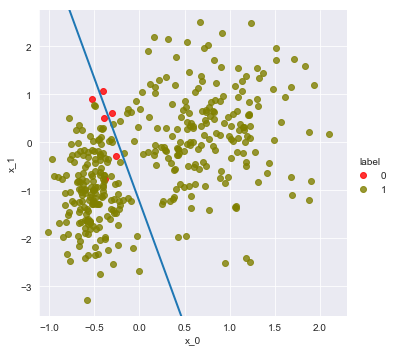

In [29]:
MAX_STEP = 10

# Get the data coordinate matrix, X, and labels vector, l
X = points
y = labels.astype(dtype=float)

# Store *all* guesses, for subsequent analysis
thetas_newt = np.zeros((3, MAX_STEP+1))

for t in range(MAX_STEP):
    theta = thetas_newt[:, t:t+1]
    theta_grad = grad_log_likelihood(theta, y, X)
    theta_hess = hess_log_likelihood(theta, y, X)
    s_t = - np.linalg.inv(theta_hess).dot(theta_grad) 
    thetas_newt[:, t+1:t+2] = theta + s_t

theta_newt = thetas_newt[:, MAX_STEP:]
print ("Your (hand) solution:", my_theta.T.flatten())
print ("Computed solution:", theta_newt.T.flatten())

print ("\n=== Comparisons ===")
display (Math (r'\dfrac{\theta_0}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[0]/my_theta[2], \
      ", vs. MLE (via Newton's method), which is", theta_newt[0]/theta_newt[2])
display (Math (r'\dfrac{\theta_1}{\theta_2}:'))
print ("Your manual (hand-picked) solution is", my_theta[1]/my_theta[2], \
      ", vs. MLE (via Newton's method), which is", theta_newt[1]/theta_newt[2])

print ("\n=== The MLE solution, visualized ===")
newt_labels = gen_lin_discr_labels(points, theta_newt)
df_newt = df.copy()
df_newt['label'] = mark_matches(newt_labels, labels).astype (dtype=int)
plot_lin_discr(theta_newt, df_newt)

In [30]:
# Test cell: `logreg_mle_newt__check`

print ("\n=== Mismatch counts ===")

my_labels = gen_lin_discr_labels (points, my_theta)
my_mismatches = len (labels) - count_matches (labels, my_labels)
print ("Your manual (hand-picked) solution has", num_mismatches, "mismatches.")

newt_labels = gen_lin_discr_labels (points, theta_newt)
newt_mismatches = len (labels) - count_matches (labels, newt_labels)
print ("The MLE+Newton method produces", newt_mismatches, "mismatches.")

assert newt_mismatches <= ga_mismatches
print ("\n(Passed.)")


=== Mismatch counts ===
Your manual (hand-picked) solution has 6 mismatches.
The MLE+Newton method produces 6 mismatches.

(Passed.)


The following cell creates a contour plot of the log-likelihood, as done previously in this notebook. Add code to display the trajectory taken by Newton's method.

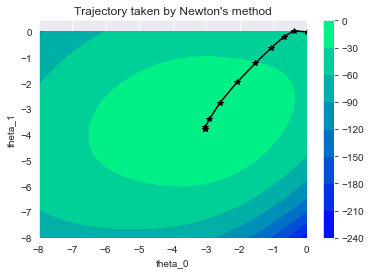

In [31]:
p = plt.contourf(x1, x2, ll_grid, cmap=plt.cm.get_cmap("winter"))
plt.xlabel('theta_0')
plt.ylabel('theta_1')
plt.title('Trajectory taken by Newton\'s method')
plt.colorbar()
plt.plot(thetas_newt[1, :], thetas_newt[2, :], 'k*-')

How many steps does this optimization procedure take compared to gradient ascent? What is the tradeoff?

**Fin!** This notebook ends here. Don't forget to submit it!